In [26]:
import pandas as pd
import numpy as np

data2019 = pd.read_csv("./FullData2019.csv")
data2019 = data2019.drop_duplicates('hhid').reset_index(drop=True)
data2016 = pd.read_csv("./FullData2016.csv")
def FCSStaus(val):
    if val <=21:
        return 1
    else:
        return 0
# create the binary food insecurity indicator
data2019['FCSStaus'] = data2019['FCS'].apply(FCSStaus)
data2016['FCSStaus'] = data2016['FCS'].apply(FCSStaus)
# create a lagged FCS
data2016['dismerge'] = data2016['s1aq2a'].str.upper()
mg2016 = data2016[['FCSStaus','dismerge']].groupby('dismerge').mean().reset_index()
mg2016.rename(columns={'dismerge':'s1aq2a', 'FCSStaus':'FCSStaus_lag'}, inplace=True)
data2019['FCSStaus_lag'] = pd.merge(data2019, mg2016, on='s1aq2a', how='left')['FCSStaus_lag']

# imputation for NA, with mode  
individual = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'ShareToilet', 'Income', 'Kind Income Ratio', 'Salt', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd',
       'OwnNow_ArgLand', 'valueNow_ArgLand', 'Own1yrAgo_ArgLand',
       'ValueAgo_ArgLand', 'OwnNow_TV', 'valueNow_TV', 'Own1yrAgo_TV',
       'ValueAgo_TV', 'OwnNow_FixPhone', 'valueNow_FixPhone',
       'Own1yrAgo_FixPhone', 'ValueAgo_FixPhone', 'OwnNow_MobilePhone',
       'valueNow_MobilePhone', 'Own1yrAgo_MobilePhone', 'ValueAgo_MobilePhone','OwnNow_Refrigerator', 'valueNow_Refrigerator',
       'Own1yrAgo_Refrigerator', 'ValueAgo_Refrigerator', 'OwnNow_Furniture',
       'valueNow_Furniture', 'Own1yrAgo_Furniture', 'ValueAgo_Furniture','OwnNow_Cooker', 'valueNow_Cooker', 'Own1yrAgo_Cooker',
       'ValueAgo_Cooker', 'OwnNow_Livestock', 'valueNow_Livestock','Own1yrAgo_Livestock', 'ValueAgo_Livestock','valueNowTotal',
       'ValueAgoTotal','FamilySize','SelfStapleTypes','FCSStaus_lag'] # ShareToilet and Salt are dummies 

for i in individual: 
    # data2016[i].fillna(data2016[i].mode()[0],inplace=True)
    data2019[i].fillna(data2019[i].mode()[0],inplace=True)
# wkd2016 = pd.get_dummies(data2016,columns=["ShareToilet","Salt"])
wkd2019 = pd.get_dummies(data2019,columns=["ShareToilet","Salt"])
wkd2019_2 = pd.get_dummies(wkd2019,columns=["IncomeStab",'SubjectivePoverty', 'RelLivStandard','LivStandChange'])
# frequency encoding 
# freq = ['HouseType', 'RoofType', 'WaterSource',
#        'DistDrinkingWater', 'SubjectivePoverty', 'RelLivStandard',
#        'IncomeStab', 'LivStandChange']
freq = ['HouseType', 'RoofType', 'WaterSource']

wkd2019_2['DistDrinkingWaterBig3'] = wkd2019_2['DistDrinkingWater'].replace({'0-3':0, "3-5":1, "5-8":1,'8 or more KMs':1 })
# for i in freq: 
#     freqf = data2016.groupby(i).size()/len(data2016)
#     wkd2016[f"{i}_feq"] = wkd2016[i].apply(lambda x : freqf[x])
for j in freq: 
    freqf = wkd2019_2.groupby(j).size()/len(wkd2019_2)
    wkd2019_2[f"{j}_feq"] = wkd2019_2[j].apply(lambda x : freqf[x])
    
wkd2019_2['fatalitiesMean'] = wkd2019_2[['fatalities', 'fatalities lag1', 'fatalities lag2', 'fatalities lag3',
       'fatalities lag4']].sum(axis=1)
wkd2019_2['temperatureMean'] = wkd2019_2[['temperature', 'temperature lag1',
       'temperature lag2', 'temperature lag3', 'temperature lag4']].mean(axis=1)
wkd2019_2['precipitationMean'] = wkd2019_2[['precipitation', 'precipitation lag1', 'precipitation lag2',
       'precipitation lag3', 'precipitation lag4']].mean(axis=1)
wkd2019_2['NDVIMean'] = wkd2019_2[['NDVI', 'NDVI lag1', 'NDVI lag2', 'NDVI lag3', 'NDVI lag4']].mean(axis=1)
wkd2019_2['NDVI Anomaly Mean'] = wkd2019_2[['NDVI Anomaly',
       'NDVI Anomaly lag1', 'NDVI Anomaly lag2', 'NDVI Anomaly lag3',
       'NDVI Anomaly lag4']].mean(axis=1)

# feature engineering 
value_list = ['valueNow_ArgLand', "Income", 
       'valueNow_TV', 'valueNow_FixPhone',  'valueNow_MobilePhone', 'valueNow_Refrigerator', 'valueNow_Furniture', 
       'valueNow_Cooker', 'valueNow_Livestock', 'valueNowTotal', 'ValueAgoTotal']
value_list_new = [f'{i}_new' for i in value_list]
wkd2019_2[value_list_new] = np.log(wkd2019_2[value_list] + 1)*10
wkd2019_2['FamilySize_new'] =  np.log(wkd2019_2['FamilySize'])*10
wkd2019_2['SelfStapleTypes_new'] =  np.log(wkd2019_2['SelfStapleTypes'] + 1)*10

macrologList = ['NL_District', 'NL_County', 'fatalitiesMean', 'temperatureMean',
       'precipitationMean', 'NDVIMean', 'NDVI Anomaly Mean', 'Kind Income Ratio', 
       'Average (mm)', '1 Month Anomaly (%)', '3 Months Anomaly (%)','MaleRatio', 'AvgAge' ]
macrologList_new = [f'{i}_log' for i in macrologList]
wkd2019_2[macrologList_new] = np.log(wkd2019_2[macrologList]+1)*10

time_splitted_data_1920 = { }

for y in [2019, 2020]:
    for m in range(1,13):
        if wkd2019_2.query("year == @y and month == @m").shape[0] != 0: 
            time_splitted_data_1920[f"{y}_{m}"] = wkd2019_2.query("year == @y and month == @m").reset_index(drop = True)
        else: 
            continue 

In [27]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer
import matplotlib.pyplot as plt
from sklearn import metrics
from python_functions.modues import StandardizerTrainTest, resampling, XGBmodelfit, XGBmodelfitTime, timeplot
from python_functions.modues import _Flexible_test_prediction, Metrics_TradeOff_Plot, variable_distribution_crosscheck
import seaborn as sns
from sklearn.utils import resample
import pickle

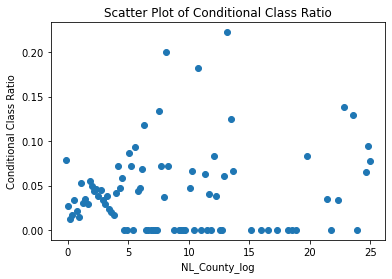

In [28]:
import numpy as np
import matplotlib.pyplot as plt

varname = 'NL_County_log'
variable_distribution_crosscheck(varname, wkd2019_2)

In [29]:
predictorList = ['FCSStaus_lag', 'urban','NL_District_log', 
       'precipitationMean', 'NDVI Anomaly Mean',
       'Average (mm)',  '1 Month Anomaly (%)', '3 Months Anomaly (%)', 
       'fatalitiesMean_log','temperatureMean_log','NDVIMean_log',
       'Kind Income Ratio','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd', 'ShareToilet_Yes', 'Salt_Yes',
       'HouseType_feq', 'RoofType_feq', 'WaterSource_feq', 'IncomeStab_Somewhat stable',
       'IncomeStab_Very unstable',
       'SubjectivePoverty_Neither poor nor rich', 'SubjectivePoverty_Poor',
       'SubjectivePoverty_Very poor', 'RelLivStandard_Better off',
       'RelLivStandard_Same', 'RelLivStandard_Worse off',
       'LivStandChange_Decreased', 'LivStandChange_Increased',
       'LivStandChange_Stayed at the same', 'DistDrinkingWaterBig3', 'FamilySize', 
       'SelfStapleTypes', 'valueNow_MobilePhone', 'valueNowTotal', 'valueNow_Furniture', 
        'valueNow_MobilePhone_new', 'valueNow_ArgLand_new', 'valueNow_ArgLand', 'valueNow_Livestock', 
       'valueNow_Furniture_new', 'valueNow_Livestock_new', 'valueNowTotal_new', 'Income_new', 'Income', 
       'ValueAgoTotal_new', 'valueNow_FixPhone',  
       'valueNow_Refrigerator']

binaryList = ['urban','Salt_Yes','ShareToilet_Yes','SelfArg', 'SelfHerd', 'IncomeStab_Somewhat stable',
       'IncomeStab_Very unstable','SubjectivePoverty_Neither poor nor rich', 'SubjectivePoverty_Poor',
       'SubjectivePoverty_Very poor', 'RelLivStandard_Better off',
       'RelLivStandard_Same', 'RelLivStandard_Worse off',
       'LivStandChange_Decreased', 'LivStandChange_Increased', 
       'LivStandChange_Stayed at the same','DistDrinkingWaterBig3']

freqList = [f"{i}_feq" for i in freq]

# nonstdList = ['valueNow_ArgLand_new', 'valueNow_TV_new', 'valueNow_FixPhone_new',
#        'valueNow_MobilePhone_new', 'valueNow_Refrigerator_new',
#        'valueNow_Furniture_new', 'valueNow_Cooker_new',
#        'valueNow_Livestock_new', 'valueNowTotal_new', 'FamilySize_new',
#        'SelfStapleTypes_new']

nonstdList = []

standardizationList = list(set(predictorList) - set(binaryList) - set(freqList) - set(nonstdList))

In [4]:
sum(wkd2019_2[predictorList].isna().sum(axis=0))

0

#### Time

In [30]:
time_splitted_data_1920.keys()

dict_keys(['2019_9', '2019_10', '2019_11', '2019_12', '2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11'])

In [31]:

date19List = [i for i in time_splitted_data_1920.keys()]
data19List = [i for i in time_splitted_data_1920.values()]

# here we generate the "time series" train and test data, we use the first 4 months in 19/20 data as the first set
# of training data, and then add one month in each round, the test data is the next month of the last train data 
trainDataStart = data19List[0].copy()

for i in range(1, 3):
    interTrainData = data19List[i].copy()
    trainDataStart = pd.concat([trainDataStart, interTrainData], axis=0)
    
trainData = {"train_2":trainDataStart.reset_index(drop = True)}
testData = {"test_2":data19List[3].reset_index(drop = True)}

for i in range(3, len(time_splitted_data_1920.keys()) - 1):
    interTrainData = pd.concat([trainData[f"train_{i - 1}"], data19List[i].copy()], axis=0)
    interTestData = data19List[i + 1].copy()
    trainData[f"train_{i}"] = interTrainData.reset_index(drop = True)
    testData[f"test_{i}"] = interTestData.reset_index(drop = True)
# standardize and resample 
StdTrain = {}
StdTest = {}
train19List = [i for i in trainData.values()]
test19List = [i for i in testData.values()]

for train, test, name1, name2 in zip(train19List, test19List,  trainData.keys(), testData.keys()):
    standardizedTrain, standardizedTest = StandardizerTrainTest(train[predictorList], test[predictorList], 
                                                                standardizationList, binaryList, freqList, nonstdList)
    standardizedTrain_withY = pd.concat([standardizedTrain,train['FCSStaus']], axis=1)
    standardizedTest_withY = pd.concat([standardizedTest,test['FCSStaus']], axis=1)
    StdTrain[f"{name1}"] = standardizedTrain_withY
    StdTest[f"{name2}"] = standardizedTest_withY

StdTrain['train_9'].shape

(12549, 51)

In [32]:
StdTest.keys()

dict_keys(['test_2', 'test_3', 'test_4', 'test_5', 'test_6', 'test_7', 'test_8', 'test_9'])

In [33]:
scoring = 'roc_auc'

AUC_LR = []
Recallvalue_LR = []
Accuracyvalue_LR = []
# auc_bootstrap_LR = {}
# recall_bootstrap_LR = {}
# accuracy_bootstrap_LR = {}

X_train = StdTrain['train_5'][predictorList]
Y_train = StdTrain['train_5']['FCSStaus']
LR_l1 = LogisticRegression(penalty='l1',random_state=527, solver='liblinear' ,
                        max_iter=1000, class_weight = 'balanced')
grid = {"C":[10**i for i in range(-3,3,1)]}
crossval = GridSearchCV(LR_l1,grid,cv=5,scoring=scoring)
crossval.fit(X_train, Y_train)
LR_l2 = LogisticRegression(penalty='l1',random_state=527,max_iter=1000,**crossval.best_params_,
                            solver='saga' ,class_weight = 'balanced')
LR_l2.fit(X_train, Y_train)

for testkey in StdTest.keys():
    auc_boot = []
    recall_boot = []
    accuracy_boot = []
    X_test = StdTest[testkey][predictorList]
    Y_test = StdTest[testkey]['FCSStaus']
    y_LRpred_test = LR_l2.predict(X_test)
    y_LRpredprob_test = LR_l2.predict_proba(X_test)[:,1]
    AUC_LR.append(roc_auc_score(Y_test, y_LRpredprob_test))
    Accuracyvalue_LR.append(accuracy_score(Y_test, y_LRpred_test))
    Recallvalue_LR.append(recall_score(Y_test, y_LRpred_test))
    # for i in range(500):
    #     X_bs, y_bs = resample(X_test, Y_test, replace=True)
    #     y_LRpred_test_boot = LR_l2.predict(X_bs)
    #     y_LRpredprob_test_boot = LR_l2.predict_proba(X_bs)[:,1]
    #     auc_boot.append(roc_auc_score(y_bs, y_LRpredprob_test_boot))
    #     accuracy_boot.append(accuracy_score(y_bs, y_LRpred_test_boot))
    #     recall_boot.append(recall_score(y_bs, y_LRpred_test_boot))
    # auc_bootstrap_LR[testkey] = auc_boot
    # recall_bootstrap_LR[testkey] = recall_boot
    # accuracy_bootstrap_LR[testkey] = accuracy_boot

In [9]:
# with open('auc_bootstrap_LR.pickle', 'wb') as handle:
#     pickle.dump(auc_bootstrap_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('recall_bootstrap_LR.pickle', 'wb') as handle:
#     pickle.dump(recall_bootstrap_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('accuracy_bootstrap_LR.pickle', 'wb') as handle:
#     pickle.dump(accuracy_bootstrap_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('AUC_LR_35.pickle', 'wb') as handle:
    pickle.dump(AUC_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Accuracyvalue_LR_35.pickle', 'wb') as handle:
    pickle.dump(Accuracyvalue_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Recallvalue_LR_35.pickle', 'wb') as handle:
    pickle.dump(Recallvalue_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### resampling logistic

In [21]:
predictorList_new = ['SubjectivePoverty_Very poor','ValueAgoTotal_new', 
         'valueNow_Furniture_new', 'RelLivStandard_Worse off', 
         'SelfStapleTypes', 'Salt_Yes', 'MaleRatio', 'FamilySize',
         'AvgAge', 'valueNow_MobilePhone']

SMOTE_Train = {}
ADASYN_Train = {}
for train, name1 in zip(StdTrain.values(),  trainData.keys()):
    X_smote, Y_smote, X_ADA, Y_ADA = resampling(train[predictorList_new], train['FCSStaus'])
    SMOTE_Train[f"{name1}"] = pd.concat([X_smote, Y_smote], axis=1)
    ADASYN_Train[f"{name1}"] = pd.concat([X_ADA, Y_ADA], axis=1)


In [12]:
scoring = 'roc_auc'

AUC_LR_ada = []
Recallvalue_LR_ada = []
Accuracyvalue_LR_ada = []
auc_bootstrap_LR_ada = {}
recall_bootstrap_LR_ada = {}
accuracy_bootstrap_LR_ada = {}

for trainkey, testkey in zip(ADASYN_Train.keys(), StdTest.keys()):
    auc_boot = []
    recall_boot = []
    accuracy_boot = []
    X_train = ADASYN_Train[trainkey][predictorList_new]
    Y_train = ADASYN_Train[trainkey]['FCSStaus']
    X_test = StdTest[testkey][predictorList_new]
    Y_test = StdTest[testkey]['FCSStaus']
    LR_l1 = LogisticRegression(penalty='l1',random_state=527, solver='liblinear' ,
                            max_iter=1000, class_weight = 'balanced')
    grid = {"C":[10**i for i in range(-3,3,1)]}
    crossval = GridSearchCV(LR_l1,grid,cv=5,scoring=scoring)
    crossval.fit(X_train, Y_train)
    LR_l2 = LogisticRegression(penalty='l1',random_state=527,max_iter=1000,**crossval.best_params_,
                               solver='saga' ,class_weight = 'balanced')
    LR_l2.fit(X_train, Y_train)
    y_LRpred_test = LR_l2.predict(X_test)
    y_LRpredprob_test = LR_l2.predict_proba(X_test)[:,1]
    AUC_LR_ada.append(roc_auc_score(Y_test, y_LRpredprob_test))
    Accuracyvalue_LR_ada.append(accuracy_score(Y_test, y_LRpred_test))
    Recallvalue_LR_ada.append(recall_score(Y_test, y_LRpred_test))
    for i in range(500):
        X_bs, y_bs = resample(X_test, Y_test, replace=True)
        y_LRpred_test_boot = LR_l2.predict(X_bs)
        y_LRpredprob_test_boot = LR_l2.predict_proba(X_bs)[:,1]
        auc_boot.append(roc_auc_score(y_bs, y_LRpredprob_test_boot))
        accuracy_boot.append(accuracy_score(y_bs, y_LRpred_test_boot))
        recall_boot.append(recall_score(y_bs, y_LRpred_test_boot))
    auc_bootstrap_LR_ada[testkey] = auc_boot
    recall_bootstrap_LR_ada[testkey] = recall_boot
    accuracy_bootstrap_LR_ada[testkey] = accuracy_boot

In [13]:
with open('auc_bootstrap_LR_ada.pickle', 'wb') as handle:
    pickle.dump(auc_bootstrap_LR_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('recall_bootstrap_LR_ada.pickle', 'wb') as handle:
    pickle.dump(recall_bootstrap_LR_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('accuracy_bootstrap_LR_ada.pickle', 'wb') as handle:
    pickle.dump(accuracy_bootstrap_LR_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('AUC_LR_ada.pickle', 'wb') as handle:
    pickle.dump(AUC_LR_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Accuracyvalue_LR_ada.pickle', 'wb') as handle:
    pickle.dump(Accuracyvalue_LR_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Recallvalue_LR_ada.pickle', 'wb') as handle:
    pickle.dump(Recallvalue_LR_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
from sklearn.ensemble import RandomForestClassifier

scoring = 'roc_auc'

AUC_RFada = []
Recallvalue_RFada = []
Accuracyvalue_RFada = []
auc_bootstrap_RFada = {}
recall_bootstrap_RFada = {}
accuracy_bootstrap_RFada = {}

for trainkey, testkey in zip(StdTrain.keys(), StdTest.keys()):
    auc_boot = []
    recall_boot = []
    accuracy_boot = []
    X_train = ADASYN_Train[trainkey][predictorList_new]
    Y_train = ADASYN_Train[trainkey]['FCSStaus']
    X_test = StdTest[testkey][predictorList_new]
    Y_test = StdTest[testkey]['FCSStaus']
    RF = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, 
                                min_samples_leaf = 100, class_weight='balanced')
    grid_rf = {'max_depth':[3, 5, 7]}
    crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)
    crossval_rf.fit(X_train, Y_train)
    RF2 = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, 
                                class_weight='balanced', **crossval_rf.best_params_)
    grid_rf2 = {"min_samples_leaf":[200,100], 'max_features' : [5,7,9]}
    crossval_rf2 = GridSearchCV(RF2,grid_rf2,cv=5,scoring=scoring)
    crossval_rf2.fit(X_train, Y_train)
    paraTinal = {**crossval_rf.best_params_, **crossval_rf2.best_params_}
    RF3 = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, 
           **paraTinal,  class_weight='balanced')
    RF3.fit(X_train, Y_train)
    y_RFpred_test = RF3.predict(X_test)
    y_RFpredProb_test = RF3.predict_proba(X_test)[:, 1]
    Recallvalue_RFada.append(recall_score(Y_test, y_RFpred_test ))
    AUC_RFada.append(roc_auc_score(Y_test, y_RFpredProb_test))
    Accuracyvalue_RFada.append(accuracy_score(Y_test, y_RFpred_test))
    for i in range(500):
        X_bs, y_bs = resample(X_test, Y_test, replace=True)
        y_RFpred_test_boot = RF3.predict(X_bs)
        y_RFpredprob_test_boot = RF3.predict_proba(X_bs)[:,1]
        auc_boot.append(roc_auc_score(y_bs, y_RFpredprob_test_boot))
        accuracy_boot.append(accuracy_score(y_bs, y_RFpred_test_boot))
        recall_boot.append(recall_score(y_bs, y_RFpred_test_boot))
    auc_bootstrap_RFada[testkey] = auc_boot
    recall_bootstrap_RFada[testkey] = recall_boot
    accuracy_bootstrap_RFada[testkey] = accuracy_boot
    

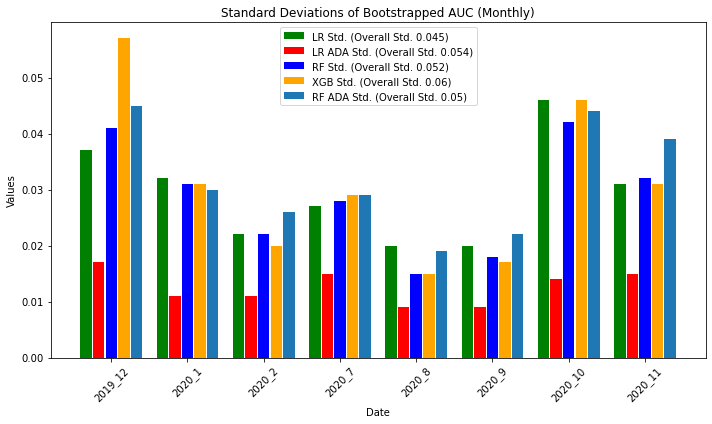

In [25]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
plotdata = {}
plotdata['Date'] = xaxis
for data, name in zip([auc_bootstrap_LR, accuracy_bootstrap_LR_ada, auc_bootstrap_RF, auc_bootstrap_xgb, auc_bootstrap_RFada], 
                      ['LR', 'LR ADA', 'RF','XGB', 'RF ADA']): 
    varList = []
    for i in data.keys():
        stats = data[i]
        varList.append(np.std(stats).round(3))
    plotdata[f"{name} Std."] = np.array(varList)
plotdata = pd.DataFrame(plotdata)
overallStdLR = np.array(pd.DataFrame(auc_bootstrap_LR)).reshape((-1,1)).std().round(3)
overallStdLRADA = np.array(pd.DataFrame(auc_bootstrap_LR_ada)).reshape((-1,1)).std().round(3)
overallStdRF = np.array(pd.DataFrame(auc_bootstrap_RF)).reshape((-1,1)).std().round(3)
overallStdXGB = np.array(pd.DataFrame(auc_bootstrap_xgb)).reshape((-1,1)).std().round(3)
overallStdRFADA = np.array(pd.DataFrame(auc_bootstrap_RFada)).reshape((-1,1)).std().round(3)
df = plotdata
# Set the figure size
plt.figure(figsize=(10, 6))
# Plot the bars
x = np.arange(len(df))
widthplot = 0.15
jitter = widthplot*1.1
plt.bar(x - 2*jitter, df['LR Std.'], label=f'LR Std. (Overall Std. {overallStdLR})', color='green', width=widthplot)
plt.bar(x - jitter, df['LR ADA Std.'], label=f'LR ADA Std. (Overall Std. {overallStdLRADA})', color='red', width=widthplot)
plt.bar(x, df['RF Std.'], label=f'RF Std. (Overall Std. {overallStdRF})', color='blue', width=widthplot)
plt.bar(x + jitter, df['XGB Std.'], label=f'XGB Std. (Overall Std. {overallStdXGB})', color='orange', width=widthplot)
plt.bar(x + 2*jitter, df['RF ADA Std.'], label=f'RF ADA Std. (Overall Std. {overallStdRFADA})', width=widthplot)
# Set x-axis tick labels
plt.xticks(x, df['Date'], rotation=45)
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Standard Deviations of Bootstrapped AUC (Monthly)')
# Add legend
plt.legend()
# Show the plot
plt.tight_layout()
plt.savefig("./figures/bootstrapStd_with adaRF.png")

In [24]:
with open('auc_bootstrap_RFada.pickle', 'wb') as handle:
    pickle.dump(auc_bootstrap_RFada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('recall_bootstrap_RFada.pickle', 'wb') as handle:
    pickle.dump(recall_bootstrap_RFada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('accuracy_bootstrap_RFada.pickle', 'wb') as handle:
    pickle.dump(accuracy_bootstrap_RFada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('AUC_RFada.pickle', 'wb') as handle:
    pickle.dump(AUC_RFada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Accuracyvalue_RFada.pickle', 'wb') as handle:
    pickle.dump(Accuracyvalue_RFada, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Recallvalue_RFada.pickle', 'wb') as handle:
    pickle.dump(Recallvalue_RFada, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Basic RF

In [34]:
from sklearn.ensemble import RandomForestClassifier

scoring = 'roc_auc'

AUC_RF = []
Recallvalue_RF = []
Accuracyvalue_RF = []
# auc_bootstrap_RF = {}
# recall_bootstrap_RF = {}
# accuracy_bootstrap_RF = {}
X_train = StdTrain['train_5'][predictorList]
Y_train = StdTrain['train_5']['FCSStaus']
RF = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, 
                            min_samples_leaf = 100, class_weight='balanced')
grid_rf = {'max_depth':[3, 5, 7]}
crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)
crossval_rf.fit(X_train, Y_train)
RF2 = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, 
                            class_weight='balanced', **crossval_rf.best_params_)
grid_rf2 = {"min_samples_leaf":[200,100], 'max_features' : [5,7,9]}
crossval_rf2 = GridSearchCV(RF2,grid_rf2,cv=5,scoring=scoring)
crossval_rf2.fit(X_train, Y_train)
paraTinal = {**crossval_rf.best_params_, **crossval_rf2.best_params_}
RF3 = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, 
        **paraTinal,  class_weight='balanced')
RF3.fit(X_train, Y_train)

for testkey in StdTest.keys():
#     auc_boot = []
#     recall_boot = []
#     accuracy_boot = []
    X_test = StdTest[testkey][predictorList]
    Y_test = StdTest[testkey]['FCSStaus']
    y_RFpred_test = RF3.predict(X_test)
    y_RFpredProb_test = RF3.predict_proba(X_test)[:, 1]
    Recallvalue_RF.append(recall_score(Y_test, y_RFpred_test ))
    AUC_RF.append(roc_auc_score(Y_test, y_RFpredProb_test))
    Accuracyvalue_RF.append(accuracy_score(Y_test, y_RFpred_test))
    # for i in range(500):
    #     X_bs, y_bs = resample(X_test, Y_test, replace=True)
    #     y_RFpred_test_boot = RF3.predict(X_bs)
    #     y_RFpredprob_test_boot = RF3.predict_proba(X_bs)[:,1]
    #     auc_boot.append(roc_auc_score(y_bs, y_RFpredprob_test_boot))
    #     accuracy_boot.append(accuracy_score(y_bs, y_RFpred_test_boot))
    #     recall_boot.append(recall_score(y_bs, y_RFpred_test_boot))
    # auc_bootstrap_RF[testkey] = auc_boot
    # recall_bootstrap_RF[testkey] = recall_boot
    # accuracy_bootstrap_RF[testkey] = accuracy_boot
    

In [15]:
# with open('auc_bootstrap_RF.pickle', 'wb') as handle:
#     pickle.dump(auc_bootstrap_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('recall_bootstrap_RF.pickle', 'wb') as handle:
#     pickle.dump(recall_bootstrap_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('accuracy_bootstrap_RF.pickle', 'wb') as handle:
#     pickle.dump(accuracy_bootstrap_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('AUC_RF35.pickle', 'wb') as handle:
    pickle.dump(AUC_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Accuracyvalue_RF35.pickle', 'wb') as handle:
    pickle.dump(Accuracyvalue_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Recallvalue_RF35.pickle', 'wb') as handle:
    pickle.dump(Recallvalue_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)

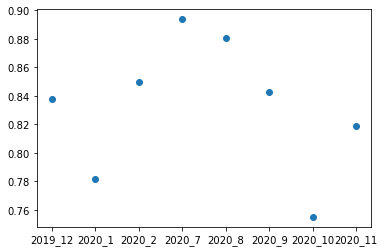

In [16]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
plt.scatter(xaxis, AUC_RF)

In [17]:
time_splitted_data_1920.keys()

dict_keys(['2019_9', '2019_10', '2019_11', '2019_12', '2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11'])

#### Basic XGBoost

In [14]:
import xgboost as xgb # use xgb.cv 
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 

In [35]:
AUC_xgb = []
Recallvalue_xgb = []
Accuracyvalue_xgb = []
# auc_bootstrap_xgb = {}
# recall_bootstrap_xgb = {}
# accuracy_bootstrap_xgb = {}
scoring = 'roc_auc'
X_train = StdTrain['train_5'][predictorList]
Y_train = StdTrain['train_5']['FCSStaus']
class_weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]
DataTrain = pd.concat([X_train,Y_train],axis=1)
param_test1 = {
'max_depth':[3,5,7],
'min_child_weight':range(1,10,3)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, max_depth=5,
min_child_weight=1, gamma=1, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight= class_weight, seed=27), 
param_grid = param_test1, scoring=scoring, n_jobs=-1, cv=5)
gsearch1.fit(X_train,Y_train)
param_test3 = {
'gamma':[i/10.0 for i in range(5,21,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, subsample=0.8, 
colsample_bytree=0.8, **gsearch1.best_params_, 
objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
param_grid = param_test3, scoring=scoring, n_jobs=-1, cv=5)
gsearch3.fit(X_train,Y_train)
param_test4 = {
'subsample':[i/10.0 for i in range(6,11,2)],
'colsample_bytree':[i/10.0 for i in range(4,9,2)]
}
para4train = {**gsearch1.best_params_,  **gsearch3.best_params_}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, 
subsample=0.8, colsample_bytree=0.8, **para4train, 
objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
param_grid = param_test4, scoring=scoring ,n_jobs=-1, cv=5)
gsearch4.fit(X_train,Y_train)
param_test6 = {'reg_lambda':[100,500,1000,1500]}
para6train = {**gsearch4.best_params_, **para4train}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=800,
            **para6train, 
objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
param_grid = param_test6, scoring=scoring , n_jobs=-1, cv=5)
gsearch6.fit(X_train,Y_train)
paraFinalTrain = {**gsearch6.best_params_, **para6train}
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=4000,
    **paraFinalTrain,
objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27)

for testkey in StdTest.keys():
    X_test = StdTest[testkey][predictorList]
    Y_test = StdTest[testkey]['FCSStaus']
    xgb_estimator, accuracy, auc, recall = XGBmodelfitTime(xgb4, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)
    AUC_xgb.append(auc)
    Accuracyvalue_xgb.append(accuracy)
    Recallvalue_xgb.append(recall)
    # for i in range(500):
    #     X_bs, y_bs = resample(X_test, Y_test, replace=True)
    #     y_xgbpred_test_boot = xgb_estimator.predict(X_bs)
    #     y_xgbpredprob_test_boot = xgb_estimator.predict_proba(X_bs)[:,1]
    #     auc_boot.append(roc_auc_score(y_bs, y_xgbpredprob_test_boot))
    #     accuracy_boot.append(accuracy_score(y_bs, y_xgbpred_test_boot))
    #     recall_boot.append(recall_score(y_bs, y_xgbpred_test_boot))
    # auc_bootstrap_xgb[testkey] = auc_boot
    # recall_bootstrap_xgb[testkey] = recall_boot
    # accuracy_bootstrap_xgb[testkey] = accuracy_boot
    

In [20]:
# with open('auc_bootstrap_xgb.pickle', 'wb') as handle:
#     pickle.dump(auc_bootstrap_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('recall_bootstrap_xgb.pickle', 'wb') as handle:
#     pickle.dump(recall_bootstrap_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('accuracy_bootstrap_xgb.pickle', 'wb') as handle:
#     pickle.dump(accuracy_bootstrap_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('AUC_xgb35.pickle', 'wb') as handle:
    pickle.dump(AUC_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Accuracyvalue_xgb35.pickle', 'wb') as handle:
    pickle.dump(Accuracyvalue_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Recallvalue_xgb35.pickle', 'wb') as handle:
    pickle.dump(Recallvalue_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
def timeplot35(xaxis,RF, xgb, LR, path, plotname): 
    rfvar = np.std(RF[3:]).round(2)
    xgbvar = np.std(xgb[3:]).round(2)
    lrvar = np.std(LR[3:]).round(2)
    plt.figure(figsize=(8,6))
    plt.scatter(xaxis, RF, label = f"Random Forest, std ({rfvar})", color ='blue')
    plt.scatter(xaxis, xgb, label = f"XGBoost, std ({xgbvar})", color ='orange', marker='x')
    plt.scatter(xaxis, LR, label = f"Logistic Regression, std ({lrvar})", color ='green', marker='v')
    rfmean = np.mean(RF[3:]).round(2)
    xgbmean = np.mean(xgb[3:]).round(2)
    lrmean = np.mean(LR[3:]).round(2)
    plt.hlines(y = rfmean,xmin=xaxis[0], xmax=xaxis[-1] ,label=f"Random Forest, mean ({rfmean})",linestyle='--')
    plt.hlines(y = xgbmean, xmin=xaxis[0], xmax=xaxis[-1],label=f"XGBoost, mean ({xgbmean})", linestyle='dotted',
            color='orange')
    plt.hlines(y = lrmean, xmin=xaxis[0], xmax=xaxis[-1],label=f"Logistic Regression, mean ({lrmean})", linestyle='--',
            color='green')
#     index_start = xaxis.index('2020_2')
#     index_end = xaxis.index('2020_7')
#     # Calculate the middle index
#     middle_index = (index_start + index_end) // 2
    # Add a vertical line at the middle index
    # plt.axvline(x=middle_index, color='red', linestyle='--', alpha = 0.5)
    plt.ylim(0, 1)
    # Rotate x-axis labels (optional)
    plt.xticks(rotation=45)
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(plotname)
    # Add a legend
    plt.legend(loc = 'lower right')
    plt.grid(which = "major", linewidth = 1)
    plt.grid(which = "minor", linewidth = 0.3)
    plt.minorticks_on()
    plt.savefig(path)

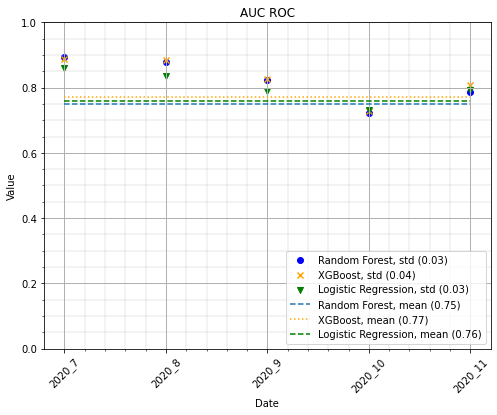

In [48]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
timeplot35(xaxis[3:], AUC_RF[3:], AUC_xgb[3:], AUC_LR[3:], "./figures/TimeAUC35.png", 'AUC ROC')

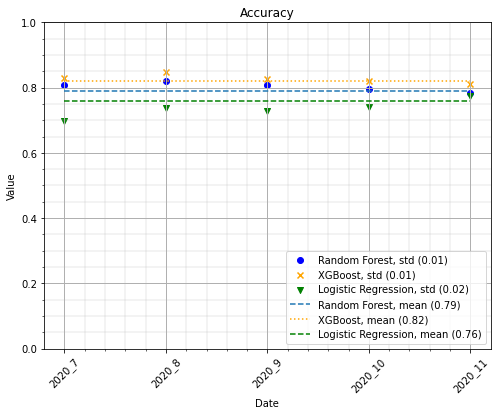

In [49]:
timeplot35(xaxis[3:], Accuracyvalue_RF[3:], Accuracyvalue_xgb[3:], Accuracyvalue_LR[3:], "./figures/TimeAccuracy35.png", 
         'Accuracy')

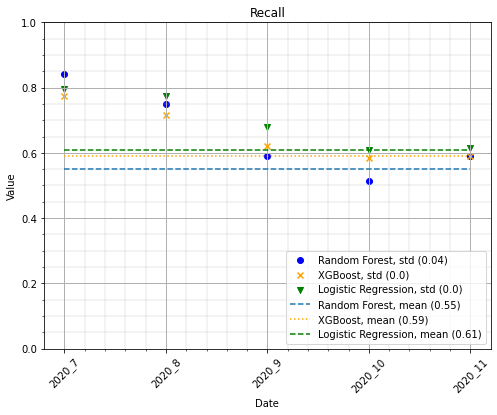

In [50]:
timeplot35(xaxis[3:], Recallvalue_RF[3:], Recallvalue_xgb[3:], Recallvalue_LR[3:], "./figures/TimeRecall35.png", 
         'Recall')

In [32]:
df = pd.DataFrame({"Time":xaxis, "AUC_RF":AUC_RF, "AUC_XGB":AUC_xgb, "AUC_LR":AUC_LR,
     "recall_RF":Recallvalue_RF, "recall_XGB":Recallvalue_xgb, "recall_LR":Recallvalue_LR ,
    "accuracy_RF":Accuracyvalue_RF, "accuracy_XGB":Accuracyvalue_xgb, "accuracy_LR":Accuracyvalue_LR })
df.to_csv("TimeSeriesResults.csv", index=False)

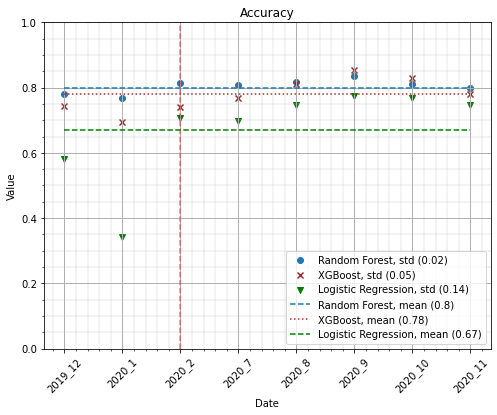

In [55]:
timeplot(xaxis, Accuracyvalue_RF, Accuracyvalue_xgb, Accuracyvalue_LR, "./figures/TimeAccuracy.png", 
         'Accuracy')

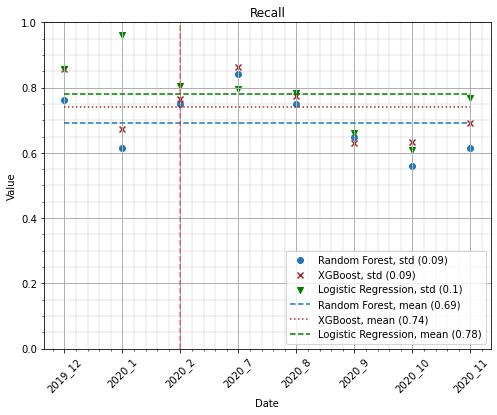

In [56]:
timeplot(xaxis, Recallvalue_RF, Recallvalue_xgb, Recallvalue_LR, "./figures/TimeRecall.png", 
         'Recall')

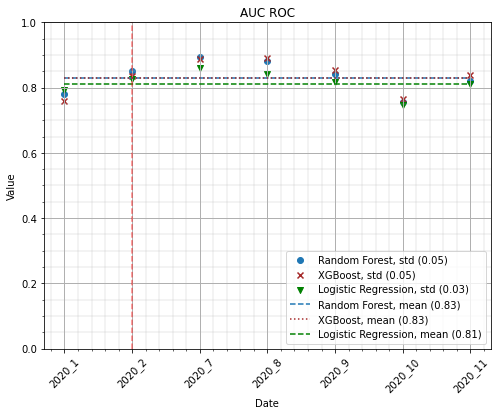

In [57]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
timeplot(xaxis[1:], AUC_RF[1:], AUC_xgb[1:], AUC_LR[1:], "./figures/TimeAUC_1.png", 'AUC ROC')

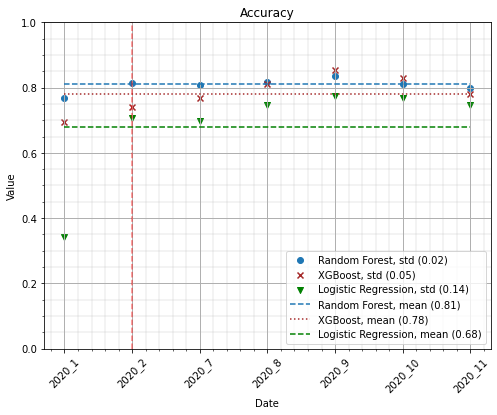

In [58]:
timeplot(xaxis[1:], Accuracyvalue_RF[1:], Accuracyvalue_xgb[1:], Accuracyvalue_LR[1:], "./figures/TimeAccuracy_1.png", 
         'Accuracy')

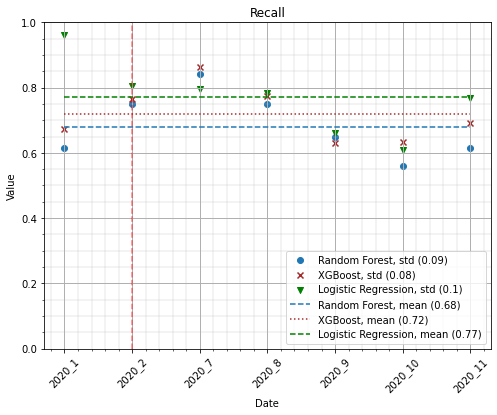

In [59]:
timeplot(xaxis[1:], Recallvalue_RF[1:], Recallvalue_xgb[1:], Recallvalue_LR[1:], "./figures/TimeRecall_1.png", 
         'Recall')

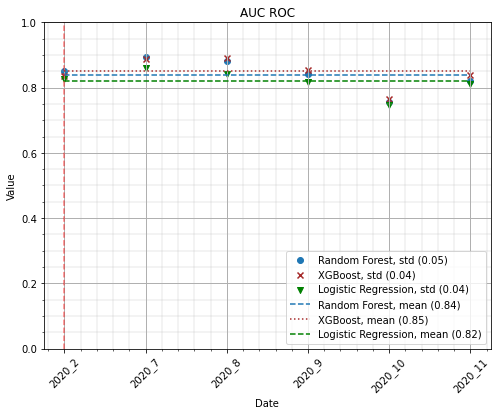

In [60]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
timeplot(xaxis[2:], AUC_RF[2:], AUC_xgb[2:], AUC_LR[2:], "./figures/TimeAUC_2.png", 'AUC ROC')

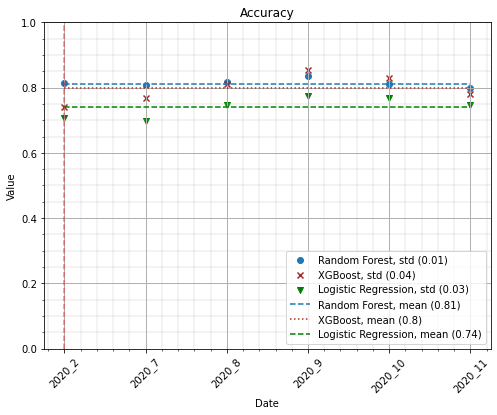

In [62]:
timeplot(xaxis[2:], Accuracyvalue_RF[2:], Accuracyvalue_xgb[2:], Accuracyvalue_LR[2:], "./figures/TimeAccuracy_2.png", 
         'Accuracy')

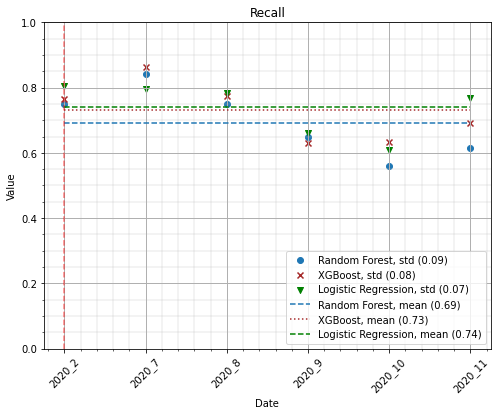

In [63]:
timeplot(xaxis[2:], Recallvalue_RF[2:], Recallvalue_xgb[2:], Recallvalue_LR[2:], "./figures/TimeRecall_2.png", 
         'Recall')